# AR(1)

## Direct Forcast

In [80]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

# Load training and testing data
training_data_path = 'US_PCE_training.xlsx'
testing_data_path = 'US_PCE_testing_fake.xlsx'

train_data = pd.read_excel(training_data_path, header = None)
test_data = pd.read_excel(testing_data_path, header=None)

# Select PCE data from loaded datasets
train_pce = train_data.iloc[1,1:].astype(float)
test_pce = test_data.iloc[1, 1:].astype(float)

# Calculate annualized inflation rate
combined_pce = pd.concat([train_pce, test_pce], ignore_index=True)

combined_inflation_rate = np.log(combined_pce).diff() * 12
combined_inflation_rate = combined_inflation_rate.dropna()

train_inflation_rate = combined_inflation_rate[:len(train_pce)-1]
test_inflation_rate = combined_inflation_rate[len(train_pce)-1:]

# Fit AR1 models with different horizons
def fit_ar1_model(data, horizons):
    y = data[horizons:]
    X = data.shift(horizons)[horizons:]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    
    return results

ar1_model_1m = fit_ar1_model(train_inflation_rate, 1)
ar1_model_3m = fit_ar1_model(train_inflation_rate, 3)
ar1_model_12m = fit_ar1_model(train_inflation_rate, 12)

ar1_model_1m.summary(), ar1_model_3m.summary(), ar1_model_12m.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      1   R-squared:                       0.504
 Model:                            OLS   Adj. R-squared:                  0.504
 Method:                 Least Squares   F-statistic:                     740.6
 Date:                Wed, 15 May 2024   Prob (F-statistic):          4.77e-113
 Time:                        11:53:33   Log-Likelihood:                 1789.7
 No. Observations:                 730   AIC:                            -3575.
 Df Residuals:                     728   BIC:                            -3566.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In-sample MSE for 1-Month Model: 0.00043457980266529587
In-sample MSE for 3-Month Model: 0.0006144393178415042
In-sample MSE for 12-Month Model: 0.0006887413346311211


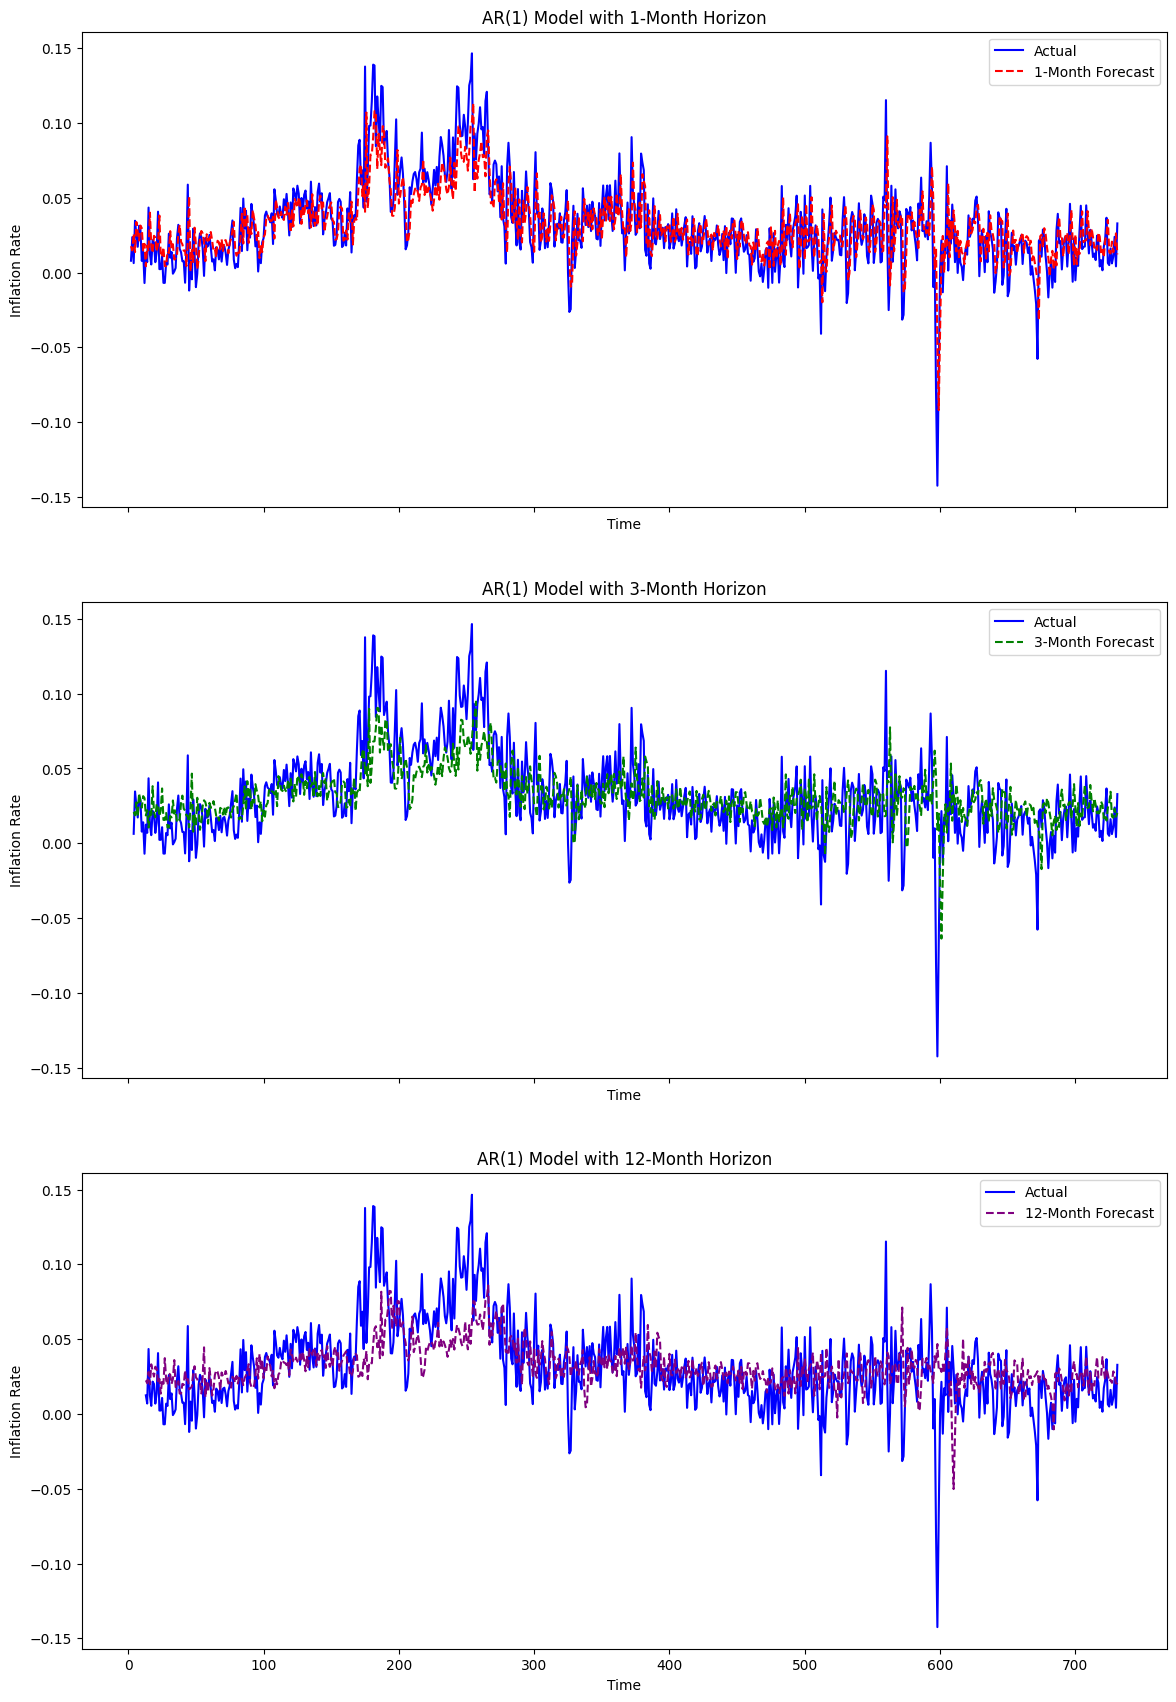

In [79]:
# Visualizing In-Sample Fit
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 21), sharex=True)
for ax, model, horizon, color in zip(axes, [ar1_model_1m, ar1_model_3m, ar1_model_12m], [1, 3, 12], ['red', 'green', 'purple']):
    predictions = model.predict(sm.add_constant(train_inflation_rate.shift(horizon)[horizon:]))
    ax.plot(train_inflation_rate.index[horizon:], train_inflation_rate[horizon:], label='Actual', color='blue')
    ax.plot(train_inflation_rate.index[horizon:], predictions, label=f'{horizon}-Month Forecast', linestyle='--', color=color)
    ax.set_title(f'AR(1) Model with {horizon}-Month Horizon')
    ax.set_xlabel('Time')
    ax.set_ylabel('Inflation Rate')
    ax.legend()
    print(f'In-sample MSE for {horizon}-Month Model:', mean_squared_error(train_inflation_rate[horizon:], predictions))

plt.show()

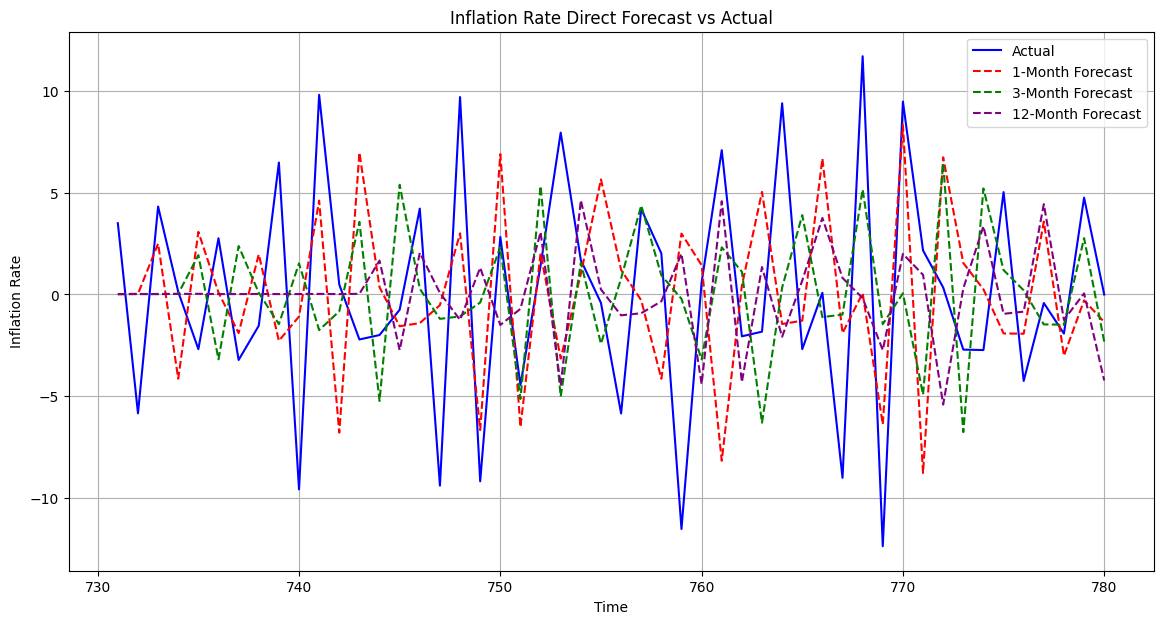

Out-of-sample MSE for 1-Month Model: 41.28845606617375
Out-of-sample MSE for 3-Month Model: 38.383399237592265
Out-of-sample MSE for 12-Month Model: 37.79809640161823


In [81]:
# Predicting and plotting out-of-sample forecasts
start_index = len(train_inflation_rate)  
end_index = start_index + len(test_inflation_rate)  

# 计算预测
predictions_1m = []
predictions_3m = []
predictions_12m = []

for i in range(start_index, end_index):
        pred_1m = ar1_model_1m.predict([1, combined_inflation_rate[i - 1]])[0]
        predictions_1m.append(pred_1m)

        pred_3m = ar1_model_3m.predict([1, combined_inflation_rate[i - 3]])[0]
        predictions_3m.append(pred_3m)


        pred_12m = ar1_model_12m.predict([1, combined_inflation_rate[i - 12]])[0]
        predictions_12m.append(pred_12m)

plt.figure(figsize=(14, 7))
actuals = combined_inflation_rate[start_index:end_index]
plt.plot(range(start_index, end_index), actuals, label='Actual', color='blue')
plt.plot(range(start_index, end_index), predictions_1m, label='1-Month Forecast', color='red', linestyle='--')
plt.plot(range(start_index, end_index), predictions_3m, label='3-Month Forecast', color='green', linestyle='--')
plt.plot(range(start_index, end_index), predictions_12m, label='12-Month Forecast', color='purple', linestyle='--')
plt.title('Inflation Rate Direct Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Print out-of-sample MSE
print('Out-of-sample MSE for 1-Month Model:', mean_squared_error(actuals, predictions_1m))
print('Out-of-sample MSE for 3-Month Model:', mean_squared_error(actuals, predictions_3m))
print('Out-of-sample MSE for 12-Month Model:', mean_squared_error(actuals, predictions_12m))

## Recursive Forcast

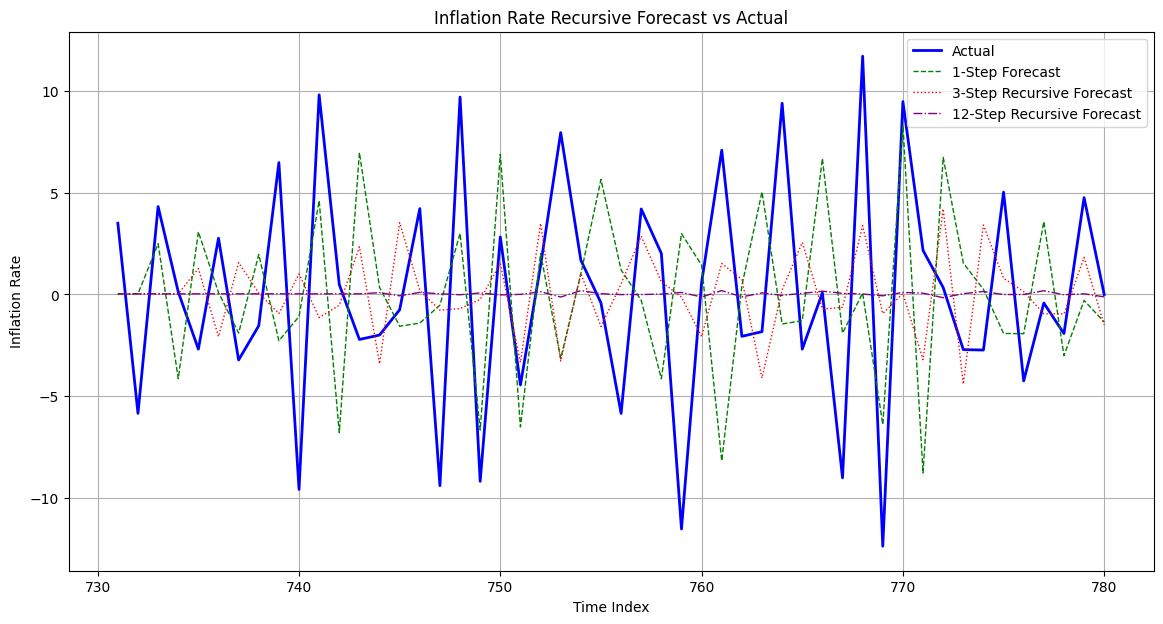

Out-of-sample MSE for 1-step: 41.28845606617375
Out-of-sample MSE for 3-step: 34.06511328477082
Out-of-sample MSE for 12-step: 32.16641163790071


In [83]:
ar1_model = ar1_model_1m

def recursive_forecast(model, start_value, steps):
    current_value = start_value
    for _ in range(steps):
        next_value = model.predict([1, current_value])[0]
        current_value = next_value
    return current_value

start_index = len(train_inflation_rate) 
end_index = start_index + len(test_inflation_rate) 

one_step_results = []
three_step_results = []
twelve_step_results = []

for t in range(start_index, end_index):
    one_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t - 1], 1)
    one_step_results.append(one_step_forecast)
    
    three_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t - 3], 3)
    three_step_results.append(three_step_forecast)

    twelve_step_forecast = recursive_forecast(ar1_model, combined_inflation_rate[t - 12], 12)
    twelve_step_results.append(twelve_step_forecast)

plt.figure(figsize=(14, 7))
plt.plot(range(start_index, end_index), combined_inflation_rate[start_index:end_index], label='Actual', color='blue', linewidth=2)
plt.plot(range(start_index, end_index), one_step_results, label='1-Step Forecast', color='green', linestyle='--', linewidth=1)
plt.plot(range(start_index, end_index), three_step_results, label='3-Step Recursive Forecast', color='red', linestyle=':', linewidth=1)
plt.plot(range(start_index, end_index), twelve_step_results, label='12-Step Recursive Forecast', color='purple', linestyle='-.', linewidth=1)
plt.title('Inflation Rate Recursive Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Calculating and displaying Out-of-sample MSE
out_of_sample_mse_1 = mean_squared_error(test_inflation_rate, one_step_results)
out_of_sample_mse_3 = mean_squared_error(test_inflation_rate, three_step_results)
out_of_sample_mse_12 = mean_squared_error(test_inflation_rate, twelve_step_results)
print('Out-of-sample MSE for 1-step:', out_of_sample_mse_1)
print('Out-of-sample MSE for 3-step:', out_of_sample_mse_3)
print('Out-of-sample MSE for 12-step:', out_of_sample_mse_12)